# Initial Thought Process

In [73]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing

In [39]:
import pandas as pd
import glob

# List of files to process
file_paths = glob.glob("data/ACSDP1Y*.csv")

# Relevant metrics to extract
relevant_metrics = [
    "    Population 16 years and over",
    "        In labor force",
    "        Median household income (dollars)",
    "    Civilian employed population 16 years and over",
    "        Educational services, and health care and social assistance",
]

# Initialize a list to store data
compiled_data = []

# Process each file
for file_path in file_paths:
    # Extract the year from the filename
    year = file_path.split("ACSDP1Y")[-1].split(".")[0]
    print(f"Processing year: {year}")
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Clean up the column names
    df.columns = df.columns.str.strip()
    
    # Ensure leading spaces in the "Label (Grouping)" column are preserved
    df["Label (Grouping)"] = df["Label (Grouping)"].str.strip(" ")
    
    # Filter relevant metrics
    filtered_df = df[df["Label (Grouping)"].notna()].copy()
    
    # Add the year column
    filtered_df["Year"] = year
    
    # Keep only the relevant columns
    filtered_df = filtered_df[["Label (Grouping)", "Peoria city, Arizona!!Estimate", "Year"]]
    filtered_df.columns = ["Metric", "Value", "Year"]
    
    # Append to the compiled data list
    compiled_data.append(filtered_df)

# Concatenate all years into a single DataFrame
final_df = pd.concat(compiled_data, ignore_index=True)

# Check for duplicates
duplicates = final_df[final_df.duplicated(subset=["Year", "Metric"], keep=False)]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
    # Optionally, remove duplicates by keeping the first occurrence
    final_df = final_df.drop_duplicates(subset=["Year", "Metric"], keep="first")

# Pivot the data to have metrics as columns and years as rows
final_pivoted_df = final_df.pivot(index="Year", columns="Metric", values="Value")

# Save the consolidated data to a CSV file
final_pivoted_df.to_csv("consolidated_acs_data.csv")
print("Consolidated data saved successfully!")


Processing year: 2021
Processing year: 2023
Processing year: 2019
Processing year: 2011
Processing year: 2022
Processing year: 2014
Processing year: 2017
Processing year: 2015
Processing year: 2013
Processing year: 2016
Processing year: 2018
Processing year: 2010
Processing year: 2012
Duplicate entries found:
                                                 Metric   Value  Year
2                                        In labor force  98,535  2021
3                                  Civilian labor force  98,442  2021
4                                              Employed  93,888  2021
11                                       In labor force  45,209  2021
12                                 Civilian labor force  45,209  2021
...                                                 ...     ...   ...
1868              With related children under 5 year...     (X)  2012
1870               With related children under 18 years     (X)  2012
1871              With related children under 5 year...    

In [60]:
ACS_DATA_FILE = "consolidated_acs_data.csv"
SMOKE_IMPACT_FILE = "data/smoke_impact_peoria.csv"

smoke_data = pd.read_csv(SMOKE_IMPACT_FILE)  # 1961-2020
economic_data = pd.read_csv(ACS_DATA_FILE)  # 2010-2023


In [61]:
economic_data.columns = economic_data.columns.str.strip()
print(economic_data.columns.tolist())


['Year', 'CLASS OF WORKER', 'COMMUTING TO WORK', 'EMPLOYMENT STATUS', 'HEALTH INSURANCE COVERAGE', 'INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2011 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2013 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2014 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2021 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)', 'INDUSTRY', 'OCCUPATION', 'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVE

In [67]:
# Filter smoke data to align with economic data timeframe (post-2010)
smoke_data['Year'] = pd.to_numeric(smoke_data['Year'], errors='coerce')

smoke_data_post_2010 = smoke_data[smoke_data['Year'] >= 2010]


# Select relevant columns from the economic data
columns_to_use = [
    'Year',
    'Civilian employed population 16 years and over',
    'Median household income (dollars)',
    'Percent Unemployed',
    'Median earnings for workers (dollars)',
    'Private wage and salary workers',
    'Self-employed in own not incorporated business workers',
    'Government workers'
]
economic_data_filtered = economic_data[columns_to_use]

economic_data_filtered = economic_data_filtered.loc[:, ~economic_data_filtered.columns.duplicated()]


# Merge datasets on overlapping years
data_merged = pd.merge(smoke_data_post_2010, economic_data_filtered, how='inner', on='Year')


In [68]:
print("Merged Data Sample:")
print(data_merged)

Merged Data Sample:
    Year  Smoke Impact Civilian employed population 16 years and over  \
0   2010     25.191242                                         70,342   
1   2011     63.309093                                         75,640   
2   2012     78.294625                                         74,114   
3   2013     25.730932                                         71,620   
4   2014     22.684927                                         78,497   
5   2015     35.837078                                         78,574   
6   2016     48.915951                                         75,236   
7   2017    152.294534                                         83,582   
8   2018     42.901263                                         82,066   
9   2019    213.502793                                         82,809   
10  2021      0.000000                                         93,888   

   Median household income (dollars) Percent Unemployed  \
0                             53,848        

In [77]:
# Derived Metrics
# Calculate Absenteeism as a percentage of employed population scaled by smoke impact
data_merged['Absenteeism'] = (
    data_merged['Smoke Impact'] * data_merged['Civilian employed population 16 years and over'] / 100
)

# Calculate Productivity Loss using Median Household Income and Smoke Impact 
data_merged['ProductivityLoss'] = (
    data_merged['Median earnings for workers (dollars)'] * data_merged['Smoke Impact'] / 100
)

print(data_merged)


    Year  Smoke Impact  Civilian employed population 16 years and over  \
0   2010     25.191242                                           70342   
1   2011     63.309093                                           75640   
2   2012     78.294625                                           74114   
3   2013     25.730932                                           71620   
4   2014     22.684927                                           78497   
5   2015     35.837078                                           78574   
6   2016     48.915951                                           75236   
7   2017    152.294534                                           83582   
8   2018     42.901263                                           82066   
9   2019    213.502793                                           82809   
10  2021      0.000000                                           93888   

    Median household income (dollars) Percent Unemployed  \
0                             53848.0              

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

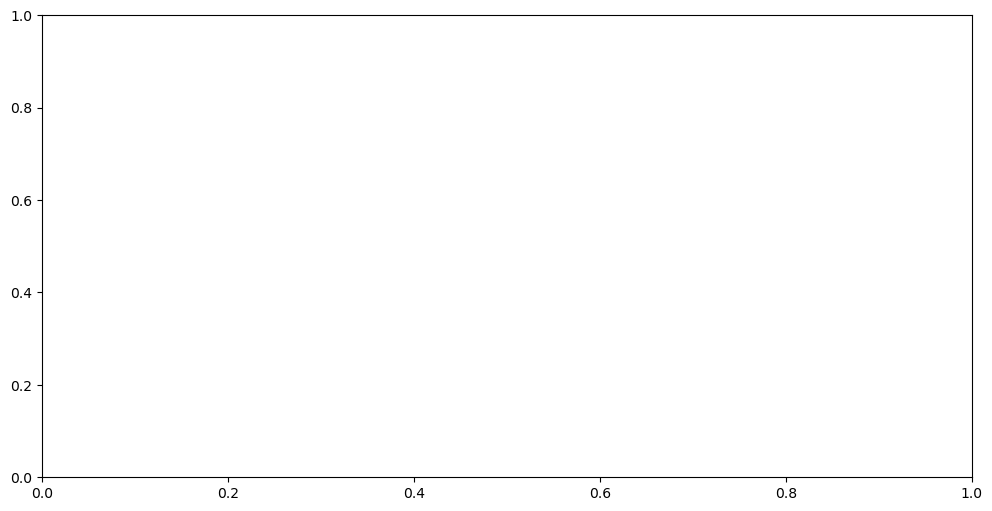

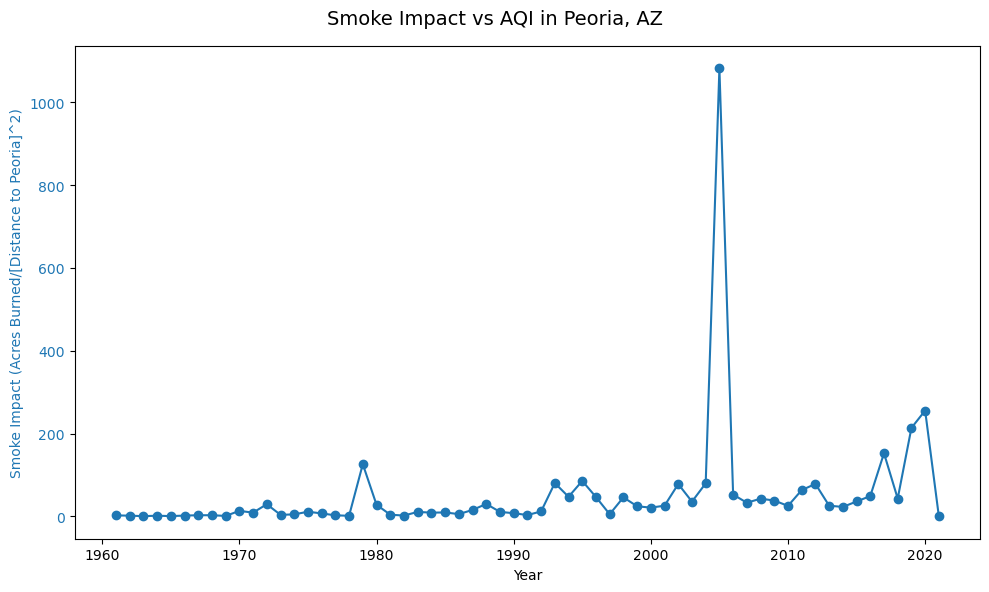

In [87]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smoke Impact
ax1.set_xlabel("Year")
ax1.set_ylabel("Smoke Impact (Acres Burned/[Distance to Peoria]^2)", color="tab:blue")
smoke_impact_line, = ax1.plot(smoke_data["Year"], smoke_data["Smoke Impact"], label="Smoke Impact", marker="o", color="tab:blue", linewidth=1.5)
ax1.tick_params(axis="y", labelcolor="tab:blue")

fig.suptitle("Smoke Impact vs AQI in Peoria, AZ", fontsize=14)
fig.tight_layout()
plt.show()

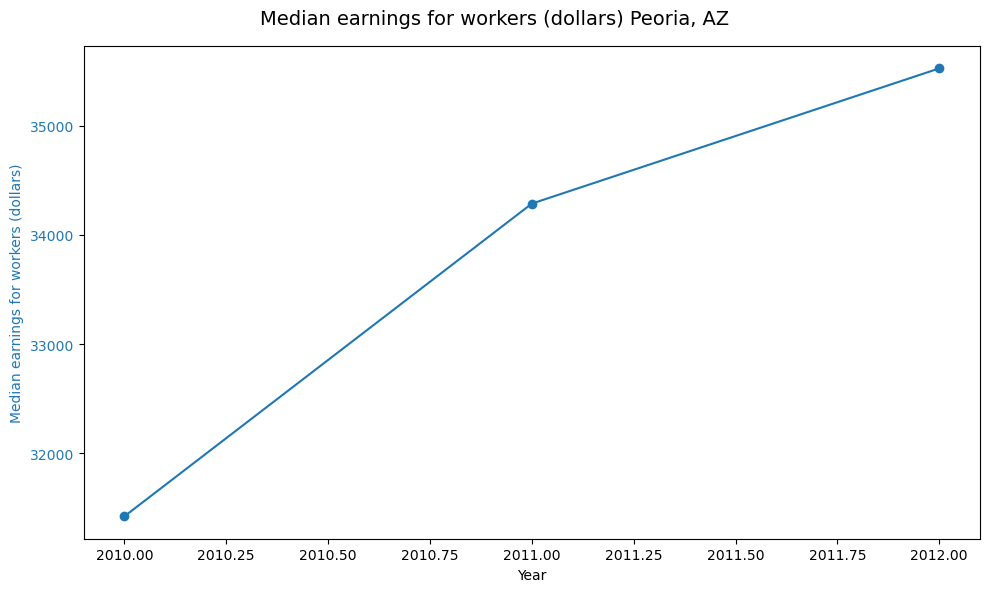

In [92]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smoke Impact
ax1.set_xlabel("Year")
ax1.set_ylabel("Median earnings for workers (dollars)", color="tab:blue")
smoke_impact_line, = ax1.plot(data_merged["Year"], data_merged["Median earnings for workers (dollars)"], label="Median earnings for workers (dollars)", marker="o", color="tab:blue", linewidth=1.5)
ax1.tick_params(axis="y", labelcolor="tab:blue")

fig.suptitle("Median earnings for workers (dollars) Peoria, AZ", fontsize=14)
fig.tight_layout()
plt.show()


## Step 2: Load and Prepare Data

In [28]:
# Load ACS data
acs_data = pd.read_csv(ACS_DATA_FILE)
# Remove leading/trailing spaces from column names
acs_data.columns = acs_data.columns.str.strip()
print("ACS Data Sample:")
print(acs_data.head())


ACS Data Sample:
   Year Civilian employed population 16 years and over  \
0  2010                                         70,342   
1  2011                                         75,640   
2  2012                                         74,114   
3  2013                                         71,620   
4  2014                                         78,497   

  Population 16 years and over  \
0                      119,817   
1                      125,277   
2                      122,423   
3                      125,238   
4                      131,763   

  Educational services, and health care and social assistance In labor force  \
0                                                NaN                     NaN   
1                                                NaN                     NaN   
2                                                NaN                     NaN   
3                                             16,891                  77,469   
4                            

In [29]:
# Load smoke impact data
smoke_data = pd.read_csv(SMOKE_IMPACT_FILE)
print("Smoke Impact Data Sample:")
print(smoke_data.head())


Smoke Impact Data Sample:
   Year  Smoke Impact
0  1961      2.222380
1  1962      1.640024
2  1963      0.400888
3  1964      1.511941
4  1965      0.544795


In [35]:
# Merge datasets on Year
merged_data = pd.merge(smoke_data, acs_data, on="Year", how="inner")

# Remove leading/trailing spaces in column names
merged_data.columns = merged_data.columns.str.strip()

# Clean numeric columns: Remove commas and cast to numeric
for col in ["Civilian employed population 16 years and over", "Median household income (dollars)"]:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col].str.replace(",", "").str.strip(), errors="coerce")

print("Merged Data Sample:")
print(merged_data)

Merged Data Sample:
    Year  Smoke Impact  Civilian employed population 16 years and over  \
0   2010     25.191242                                           70342   
1   2011     63.309093                                           75640   
2   2012     78.294625                                           74114   
3   2013     25.730932                                           71620   
4   2014     22.684927                                           78497   
5   2015     35.837078                                           78574   
6   2016     48.915951                                           75236   
7   2017    152.294534                                           83582   
8   2018     42.901263                                           82066   
9   2019    213.502793                                           82809   
10  2021      0.000000                                           93888   

   Population 16 years and over  \
0                       119,817   
1                    

In [32]:
# Inspect column data and types
print(merged_data[["Year", "Civilian employed population 16 years and over", 
                   "Median household income (dollars)", "Smoke Impact"]].info())

print(merged_data[["Year", "Civilian employed population 16 years and over", 
                   "Median household income (dollars)", "Smoke Impact"]].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Year                                            11 non-null     int64  
 1   Civilian employed population 16 years and over  11 non-null     int64  
 2   Median household income (dollars)               8 non-null      float64
 3   Smoke Impact                                    11 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 480.0 bytes
None
   Year  Civilian employed population 16 years and over  \
0  2010                                           70342   
1  2011                                           75640   
2  2012                                           74114   
3  2013                                           71620   
4  2014                                           78497   

   Median household i

## Step 3: Calculate Derived Metrics

In [34]:
# Calculate derived metrics
merged_data["Absenteeism"] = (
    merged_data["Civilian employed population 16 years and over"] * 0.01 * merged_data["Smoke Impact"]
)
merged_data["Productivity Loss"] = (
    merged_data["Median household income (dollars)"] * 0.05 * merged_data["Smoke Impact"]
)

# View updated metrics
print("Data with Derived Metrics:")
print(merged_data[["Year", "Absenteeism", "Productivity Loss"]])


Data with Derived Metrics:
    Year    Absenteeism  Productivity Loss
0   2010   17720.023538                NaN
1   2011   47886.997833                NaN
2   2012   58027.278139                NaN
3   2013   18428.493465       76391.277331
4   2014   17806.987111       75281.064343
5   2015   28158.625676      118814.248438
6   2016   36802.404616      168471.425564
7   2017  127290.817373      549341.613441
8   2018   35207.350239      154551.798840
9   2019  176799.527695      825914.203690
10  2021       0.000000           0.000000


Data with Derived Metrics:
    Year    Absenteeism  Productivity Loss
0   2010   17720.023538                NaN
1   2011   47886.997833                NaN
2   2012   58027.278139                NaN
3   2013   18428.493465       15278.255466
4   2014   17806.987111       15056.212869
5   2015   28158.625676       23762.849688
6   2016   36802.404616       33694.285113
7   2017  127290.817373      109868.322688
8   2018   35207.350239       30910.359768
9   2019  176799.527695      165182.840738
10  2021       0.000000           0.000000


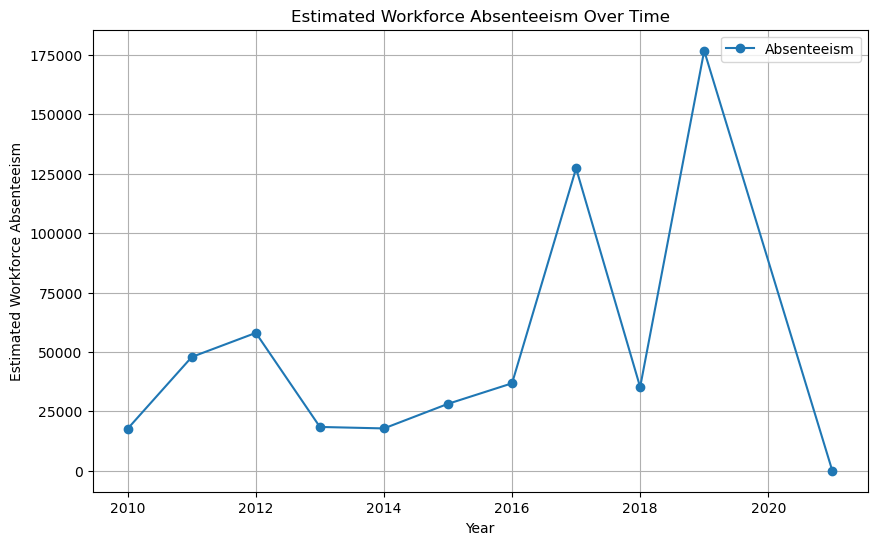

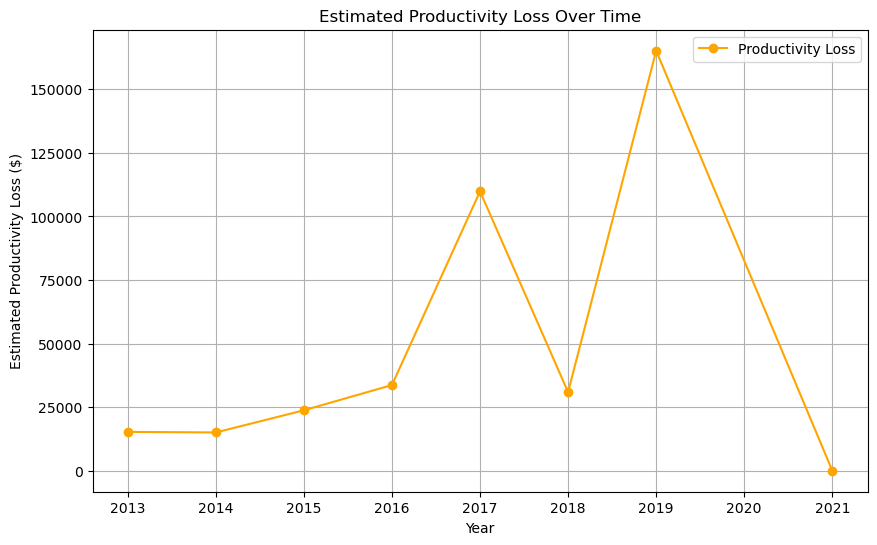

Correlation between Smoke Impact and Absenteeism: 1.00
Correlation between Smoke Impact and Productivity Loss: 1.00


In [36]:
# Derive metrics directly from the data without assumptions
# Absenteeism: percentage of employed population based on smoke impact
merged_data["Absenteeism"] = (
    merged_data["Civilian employed population 16 years and over"] 
    * merged_data["Smoke Impact"] 
    * 0.01
)

# Productivity loss: calculated directly from median household income and smoke impact
merged_data["Productivity Loss"] = (
    merged_data["Median household income (dollars)"] 
    * merged_data["Smoke Impact"] 
    * 0.01
)

# View the updated data
print("Data with Derived Metrics:")
print(merged_data[["Year", "Absenteeism", "Productivity Loss"]])

# Plot Absenteeism over the years
plt.figure(figsize=(10, 6))
plt.plot(merged_data["Year"], merged_data["Absenteeism"], marker="o", label="Absenteeism")
plt.xlabel("Year")
plt.ylabel("Estimated Workforce Absenteeism")
plt.title("Estimated Workforce Absenteeism Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Productivity Loss over the years
plt.figure(figsize=(10, 6))
plt.plot(merged_data["Year"], merged_data["Productivity Loss"], marker="o", color="orange", label="Productivity Loss")
plt.xlabel("Year")
plt.ylabel("Estimated Productivity Loss ($)")
plt.title("Estimated Productivity Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Save the derived dataset
# merged_data.to_csv("data/derived_economic_impact.csv", index=False)

# Exploratory analysis for deriving true percentages
# Correlation between Smoke Impact and economic metrics
correlation_absenteeism = merged_data[["Smoke Impact", "Absenteeism"]].corr().iloc[0, 1]
correlation_productivity = merged_data[["Smoke Impact", "Productivity Loss"]].corr().iloc[0, 1]
print(f"Correlation between Smoke Impact and Absenteeism: {correlation_absenteeism:.2f}")
print(f"Correlation between Smoke Impact and Productivity Loss: {correlation_productivity:.2f}")

# STOCK DATA


In [105]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import time

# Your Alpha Vantage API Key
api_key = "9VAEN3LYZ9T9KB0K"

# Initialize the TimeSeries object
ts = TimeSeries(key=api_key, output_format='pandas')

# List of tickers for the companies you're interested in
tickers = ['ON', 'AMKR', 'FSLR', 'KNX', 'WAL', 'CVNA', 'SFM', 'NSIT', 'AVT']

# Dictionary to store the data for each ticker
stock_data = {}

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        # Get monthly stock data
        data, meta_data = ts.get_monthly(symbol=ticker)
        stock_data[ticker] = data
        print(f"Data for {ticker} fetched successfully.")
        
        # Wait to avoid hitting the API rate limit (5 API calls per minute for free tier)
        time.sleep(12)
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Combine all stock data into a single DataFrame and save as a CSV
if stock_data:
    combined_data = pd.concat(stock_data, axis=0)
    combined_data.to_csv("maricopa_county_stocks_monthly.csv")
    print("All data saved to 'maricopa_county_stocks_monthly.csv'")
else:
    print("No data fetched.")


Fetching data for ON...
Data for ON fetched successfully.
Fetching data for AMKR...
Data for AMKR fetched successfully.
Fetching data for FSLR...
Data for FSLR fetched successfully.
Fetching data for KNX...
Data for KNX fetched successfully.
Fetching data for WAL...
Data for WAL fetched successfully.
Fetching data for CVNA...
Data for CVNA fetched successfully.
Fetching data for SFM...
Data for SFM fetched successfully.
Fetching data for NSIT...
Data for NSIT fetched successfully.
Fetching data for AVT...
Data for AVT fetched successfully.
All data saved to 'maricopa_county_stocks_monthly.csv'


In [157]:
# Fetch S&P 500 data using Alpha Vantage
api_key = "9VAEN3LYZ9T9KB0K"

ts = TimeSeries(key=api_key, output_format='pandas')

tickers = ['SPY']

sp500_data = {}

try:
    print("Fetching S&P 500 data...")
    sp500_data, _ = ts.get_monthly(symbol="SPY")
    sp500_data.reset_index(inplace=True)
    sp500_data.rename(columns={"date": "Date", "4. close": "SP500_Close"}, inplace=True)
    sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
    sp500_data["YearMonth"] = sp500_data["Date"].dt.to_period("M")
    print("S&P 500 data fetched successfully.")
except Exception as e:
    print(f"Failed to fetch S&P 500 data: {e}")
    sp500_data = pd.DataFrame()


Fetching S&P 500 data...
S&P 500 data fetched successfully.


In [231]:
sp500_data.to_csv("sp500_monthly.csv")


In [127]:
# Load stock data
stock_data = pd.read_csv("maricopa_county_stocks_monthly.csv", index_col=[0, 1])
stock_data.reset_index(inplace=True)
stock_data.rename(columns={"level_0": "Ticker", "level_1": "Date"}, inplace=True)

# Ensure correct parsing of dates
stock_data["date"] = pd.to_datetime(stock_data["date"])

# Load smoke impact data
smoke_data = pd.read_csv("data/smoke_impact_peoria.csv")
smoke_data["YearMonth"] = pd.to_datetime(smoke_data["Year"], format="%Y").dt.to_period("M")


In [160]:
# Aggregate stock data by month
stock_data["YearMonth"] = stock_data["date"].dt.to_period("M")
monthly_data = stock_data.groupby(["Ticker", "YearMonth"])['4. close'].mean().reset_index()
monthly_data.rename(columns={"4. close": "Close"}, inplace=True)


In [161]:
# Merge with smoke data
merged_data = pd.merge(
    monthly_data, smoke_data, left_on="YearMonth", right_on="YearMonth", how="inner"
)

In [162]:
# Merge with S&P 500 data
if not sp500_data.empty:
    merged_data = pd.merge(
        merged_data, sp500_data[["YearMonth", "SP500_Close"]], on="YearMonth", how="left"
    )
    # Calculate S&P 500 percent change
    merged_data["SP500 Percent Change"] = merged_data["SP500_Close"].pct_change()


In [129]:
# Calculate percent change in stock prices
merged_data["Percent Change"] = merged_data.groupby("Ticker")["close"].pct_change()

# Drop rows with missing percent changes
merged_data.dropna(subset=["Percent Change"], inplace=True)

In [163]:
# Calculate percent change in stock prices
merged_data["Percent Change"] = merged_data.groupby("Ticker")["Close"].pct_change()

In [164]:
# Adjust stock percent change for market trends (detrending)
if "SP500 Percent Change" in merged_data.columns:
    merged_data["Adjusted Percent Change"] = (
        merged_data["Percent Change"] - merged_data["SP500 Percent Change"]
    )

# Drop rows with missing percent changes
merged_data.dropna(subset=["Percent Change"], inplace=True)

In [165]:
print(merged_data)
print(merged_data.columns)

    Ticker YearMonth  Close  Year  Smoke Impact  SP500_Close  \
1     AMKR   2001-01  22.75  2001     25.708788       137.02   
2     AMKR   2002-01  18.03  2002     77.960061       113.18   
3     AMKR   2003-01   4.89  2003     35.487014        86.06   
4     AMKR   2004-01  17.39  2004     79.620726       113.48   
5     AMKR   2005-01   4.43  2005   1081.807683       118.16   
..     ...       ...    ...   ...           ...          ...   
147    WAL   2017-01  49.38  2017    152.294534       227.53   
148    WAL   2018-01  58.66  2018     42.901263       281.90   
149    WAL   2019-01  44.28  2019    213.502793       269.93   
150    WAL   2020-01  55.23  2020    255.498890       321.73   
151    WAL   2021-01  68.18  2021      0.000000       370.07   

     SP500 Percent Change  Percent Change  Adjusted Percent Change  
1               -0.018218       -0.283465                -0.265247  
2               -0.173989       -0.207473                -0.033483  
3               -0.23961

In [166]:
# Correlation Analysis
correlation = merged_data["Smoke Impact"].corr(merged_data["Adjusted Percent Change"])
print(f"Correlation between Smoke Impact and Adjusted Percent Change in Stocks: {correlation:.2f}")


Correlation between Smoke Impact and Adjusted Percent Change in Stocks: -0.14


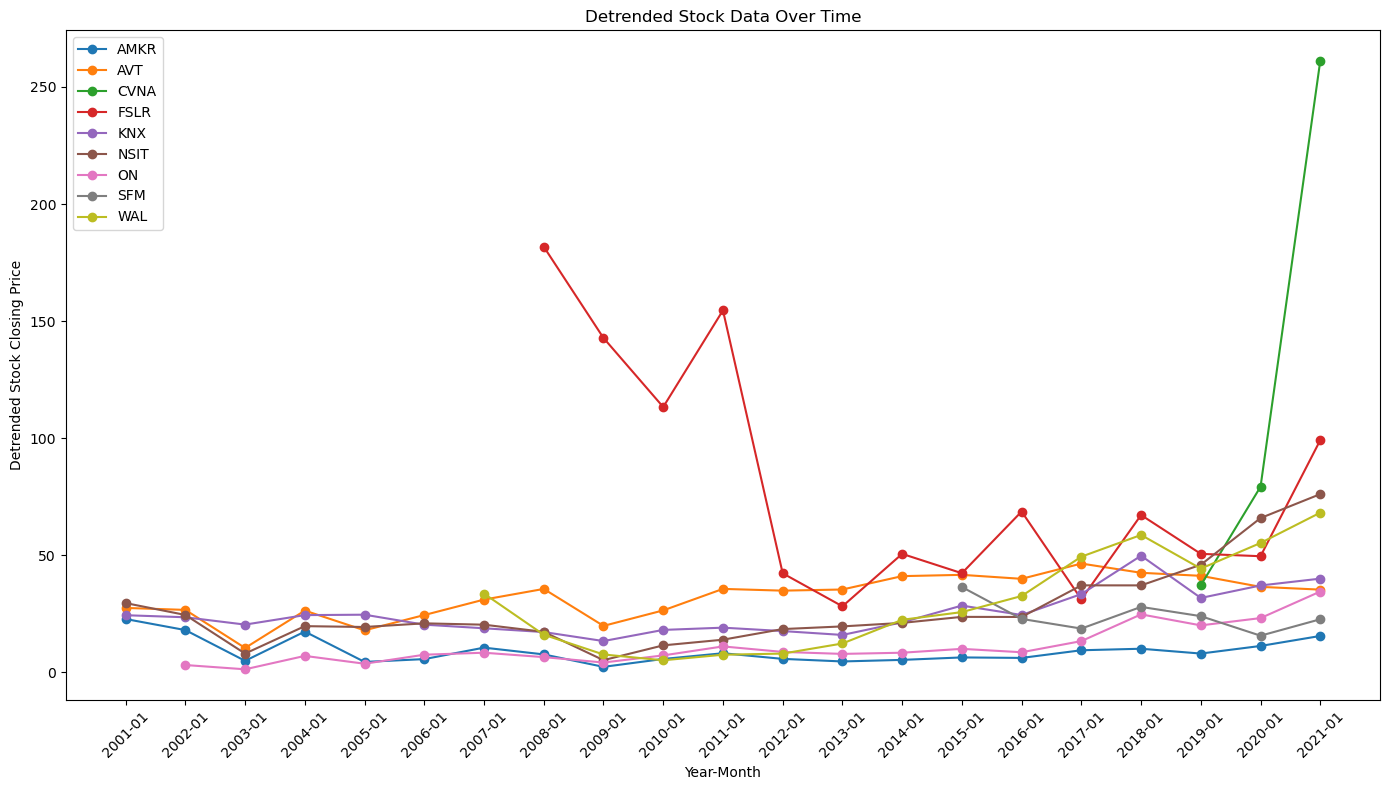

In [179]:
import matplotlib.pyplot as plt

# Plot stock data using Matplotlib
plt.figure(figsize=(14, 8))
for ticker in merged_data["Ticker"].unique():
    subset = merged_data[merged_data["Ticker"] == ticker]
    plt.plot(subset["YearMonth"].astype(str), subset["Close"], label=ticker, marker="o")

plt.title("Detrended Stock Data Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Detrended Stock Closing Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


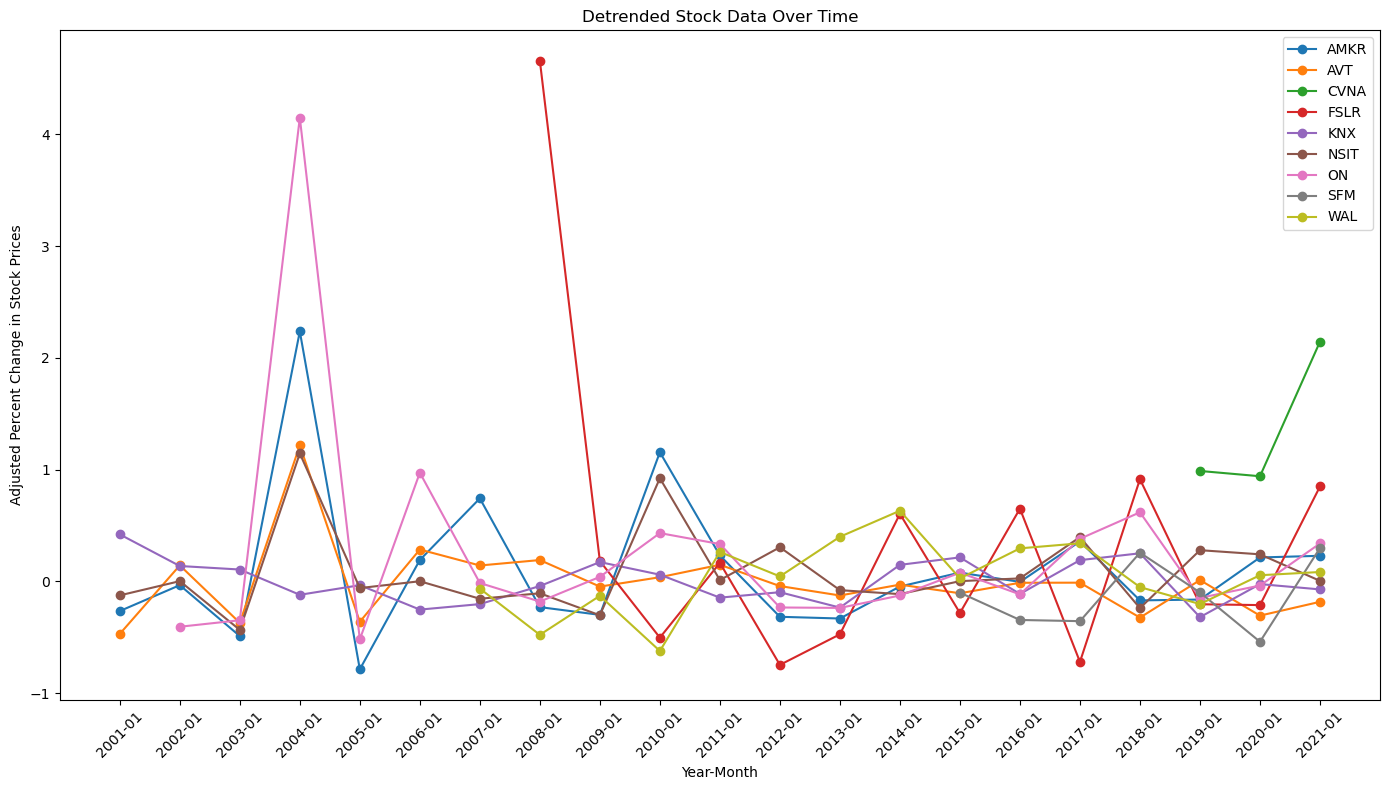

In [173]:
plt.figure(figsize=(14, 8))
for ticker in merged_data["Ticker"].unique():
    subset = merged_data[merged_data["Ticker"] == ticker]
    plt.plot(subset["YearMonth"].astype(str), subset["Adjusted Percent Change"], label=ticker, marker="o")

plt.title("Detrended Stock Data Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Adjusted Percent Change in Stock Prices")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Mention that to take out the seasonal component by making it yearly

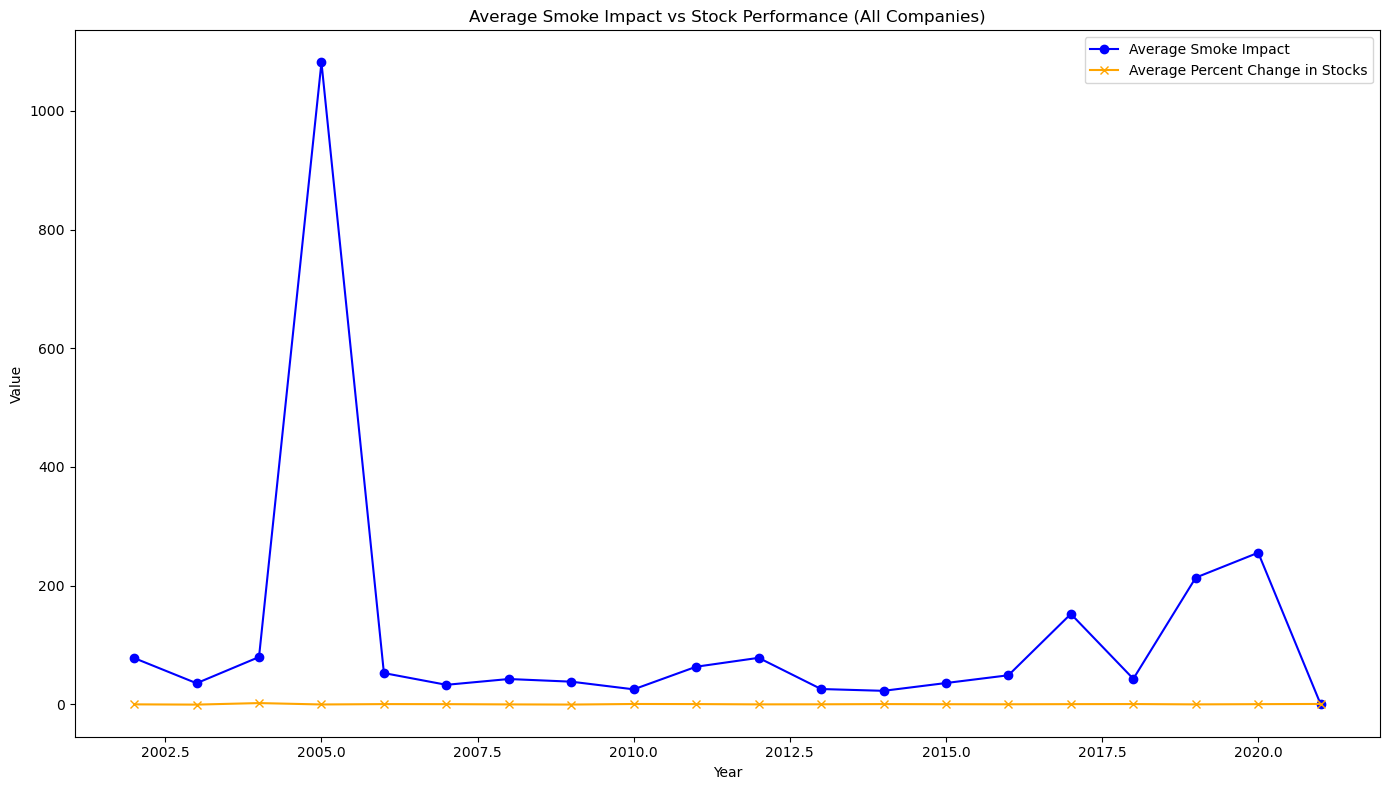

In [139]:
# Group data by year
aggregated_data = merged_data.groupby("Year")[["Smoke Impact", "Percent Change"]].mean().reset_index()

plt.figure(figsize=(14, 8))
plt.plot(aggregated_data["Year"], aggregated_data["Smoke Impact"], label="Average Smoke Impact", marker="o", color="blue")
plt.plot(aggregated_data["Year"], aggregated_data["Percent Change"], label="Average Percent Change in Stocks", marker="x", color="orange")

plt.title("Average Smoke Impact vs Stock Performance (All Companies)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


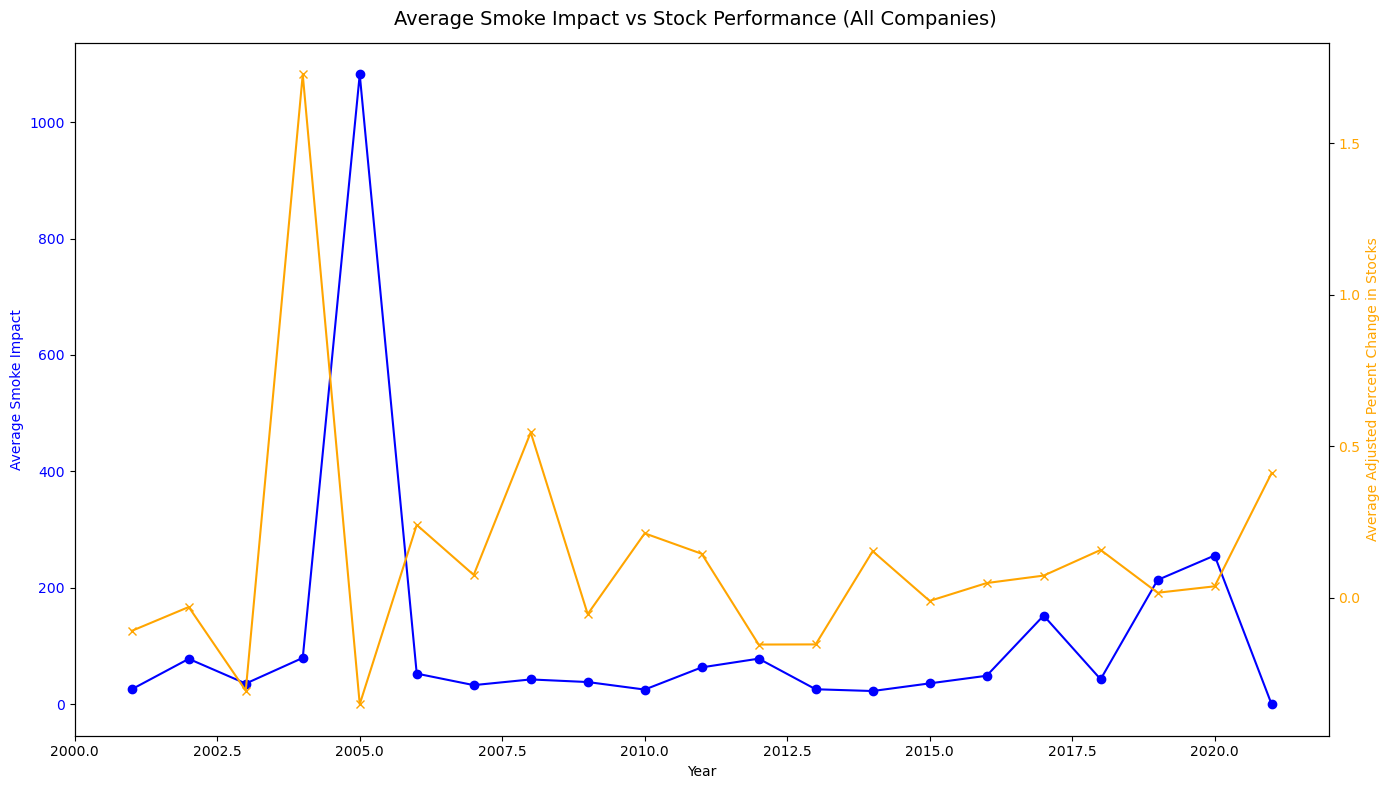

In [184]:
# Aggregate data by year
aggregated_data = merged_data.groupby("Year")[["Smoke Impact", "Adjusted Percent Change"]].mean().reset_index()

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Smoke Impact on the first y-axis
color = "blue"
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Smoke Impact", color=color)
ax1.plot(aggregated_data["Year"], aggregated_data["Smoke Impact"], label="Average Smoke Impact", marker="o", color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create a second y-axis to plot Adjusted Percent Change
ax2 = ax1.twinx()
color = "orange"
ax2.set_ylabel("Average Adjusted Percent Change in Stocks", color=color)
ax2.plot(aggregated_data["Year"], aggregated_data["Adjusted Percent Change"], label="Average Adjusted Percent Change in Stocks", marker="x", color=color)
ax2.tick_params(axis="y", labelcolor=color)

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (All Companies)", fontsize=14)
fig.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


Correlation between Smoke Impact and Percent Change in Stocks: -0.15


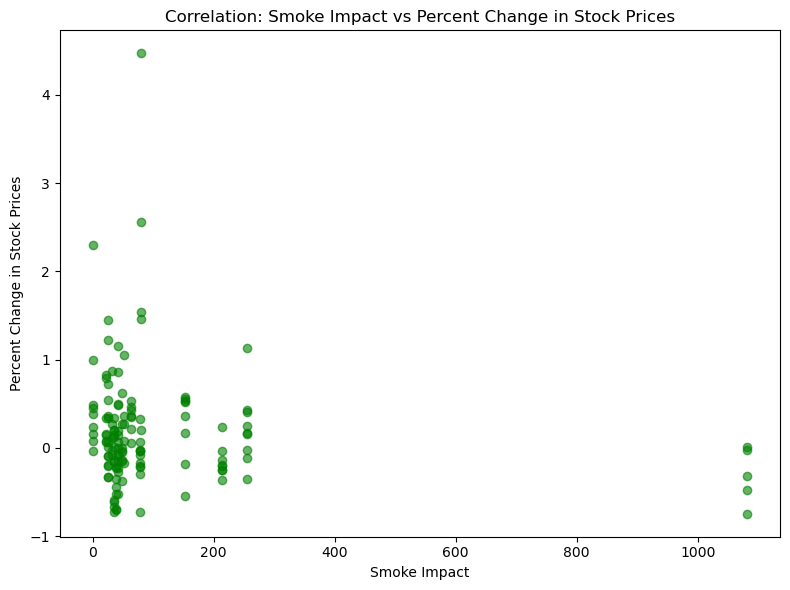

In [140]:
# Correlation
correlation = merged_data["Smoke Impact"].corr(merged_data["Percent Change"])
print(f"Correlation between Smoke Impact and Percent Change in Stocks: {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(merged_data["Smoke Impact"], merged_data["Percent Change"], alpha=0.6, color="green")
plt.title("Correlation: Smoke Impact vs Percent Change in Stock Prices")
plt.xlabel("Smoke Impact")
plt.ylabel("Percent Change in Stock Prices")
plt.tight_layout()
plt.show()


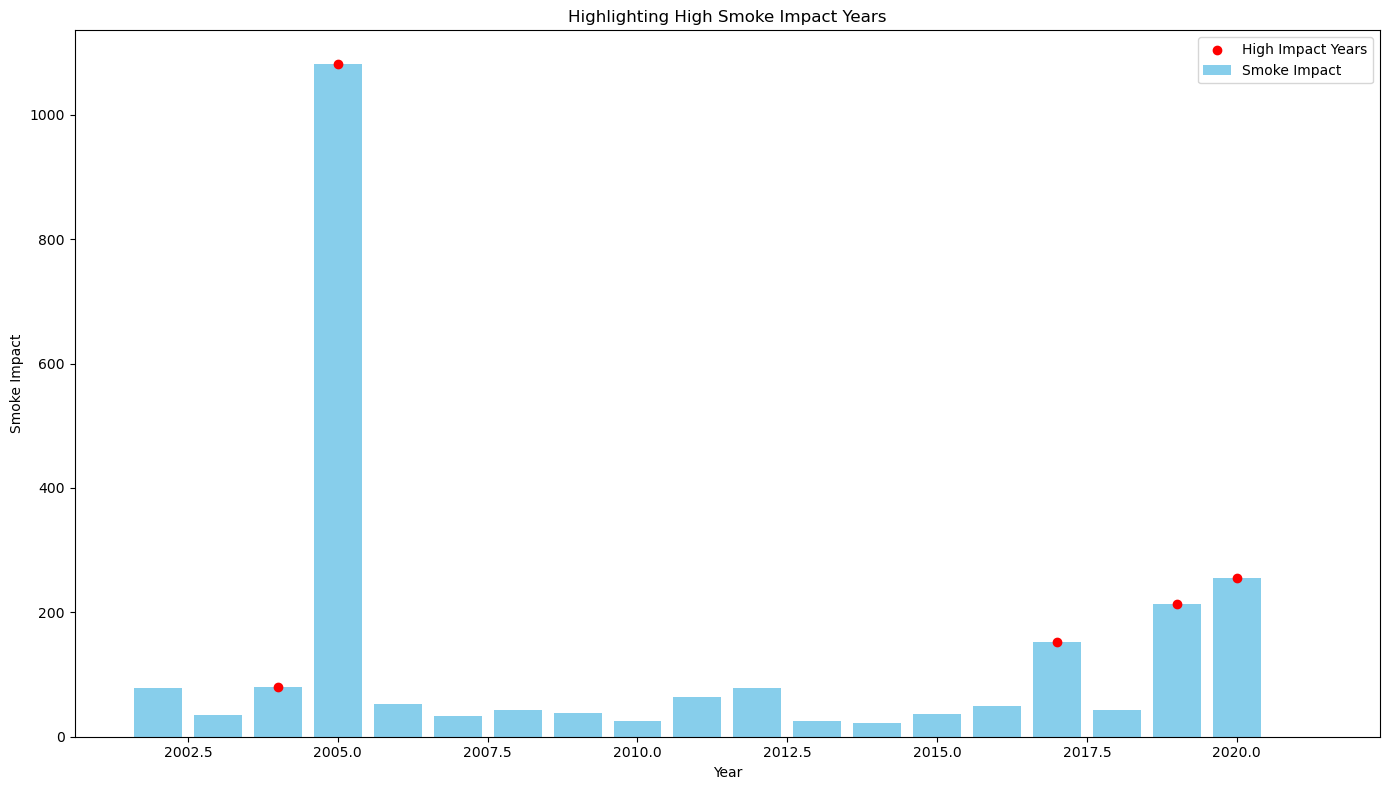

In [181]:
# Filter for years with high smoke impact
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]

plt.figure(figsize=(14, 8))
plt.bar(aggregated_data["Year"], aggregated_data["Smoke Impact"], color="skyblue", label="Smoke Impact")
plt.scatter(high_impact_years["Year"], high_impact_years["Smoke Impact"], color="red", label="High Impact Years", zorder=5)

plt.title("Highlighting High Smoke Impact Years")
plt.xlabel("Year")
plt.ylabel("Smoke Impact")
plt.legend()
plt.tight_layout()
plt.show()


In 2005, Arizona was affected by several wildfires, including the Cave Creek Complex Fire and fires near the Grand Canyon
In 2017, Boundary Fire This fire burned 17,788 acres 
2019 Woodbury Fire
2020 August Complex

# Building the Prediction Model

In [206]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [207]:
# Step 1: Prepare the Data
features = ["Smoke Impact", "SP500 Percent Change"]
target = "Adjusted Percent Change"

# Drop rows with missing data in the selected columns
model_data = merged_data.dropna(subset=features + [target])

X = model_data[features].values
y = model_data[target].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [208]:
# Step 2: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [209]:
# Step 3: Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [210]:
# Step 4: Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Cross-Validated MSE: {-np.mean(cv_scores):.4f}")

Model Performance:
Mean Squared Error (MSE): 0.8869
R² Score: -0.0011
Cross-Validated MSE: 0.4616


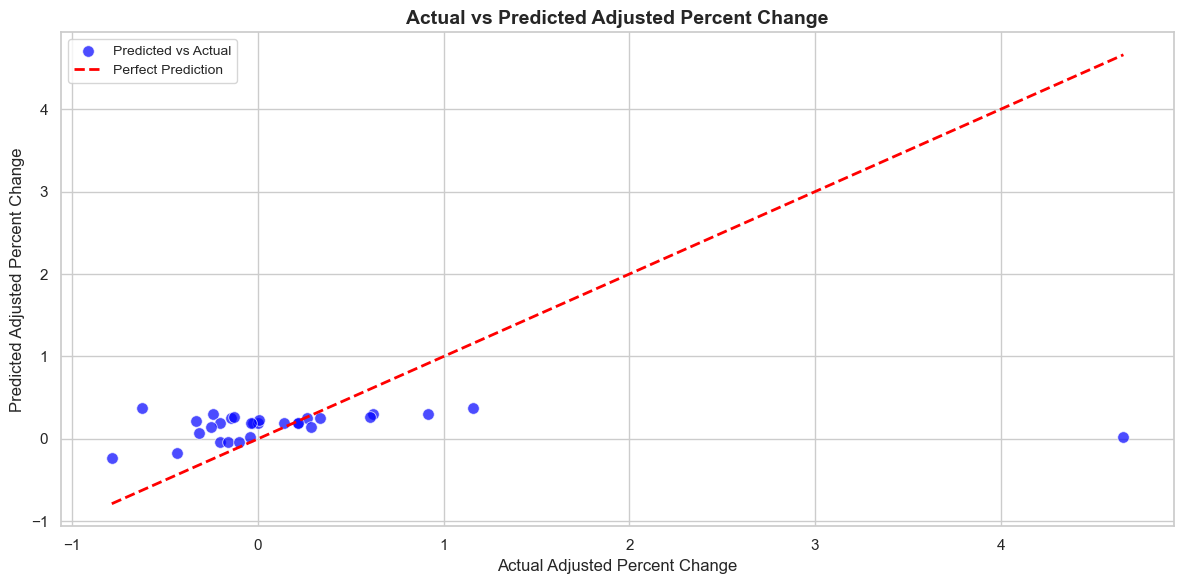

In [217]:
# Update Seaborn style
sns.set_theme(style="whitegrid")

# Step 5:  Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue", s=70, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual Adjusted Percent Change", fontsize=12)
plt.ylabel("Predicted Adjusted Percent Change", fontsize=12)
plt.title("Actual vs Predicted Adjusted Percent Change", fontsize=14, weight="bold")
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

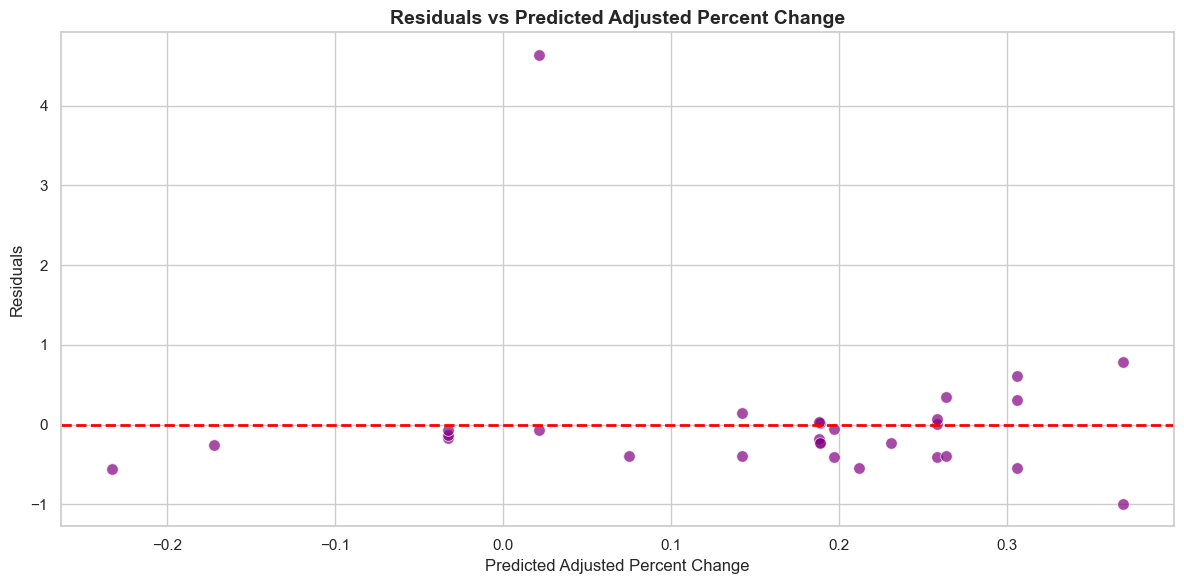

In [218]:
# Step 6: Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color="purple", s=70)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Predicted Adjusted Percent Change", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Predicted Adjusted Percent Change", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

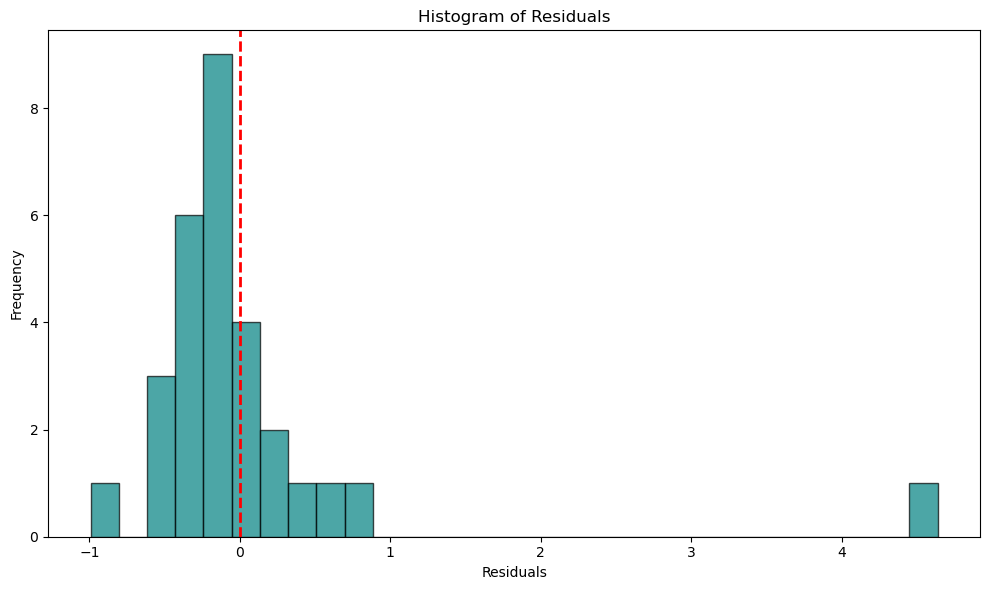

In [213]:
# Residuals Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="teal", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

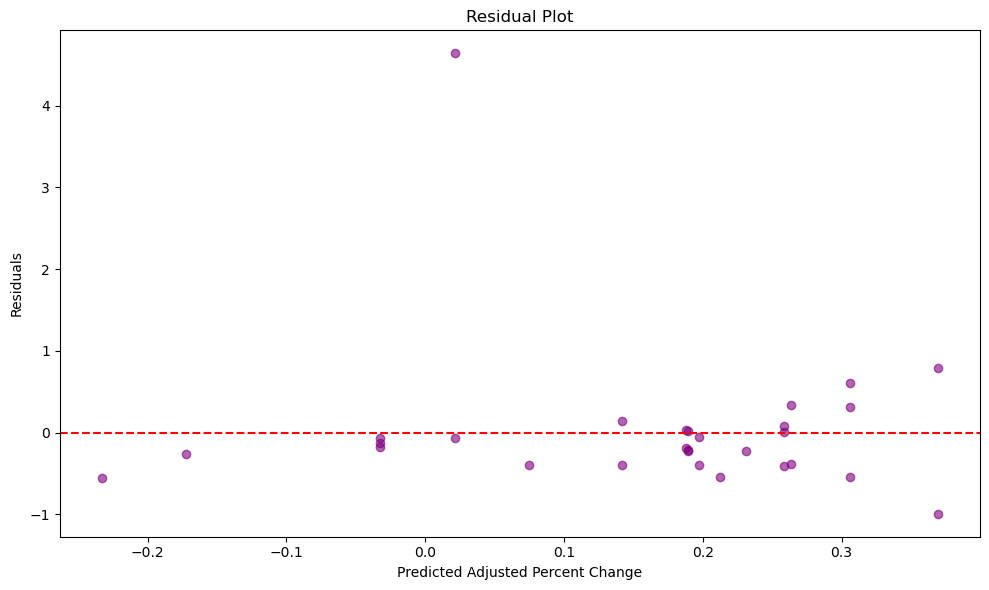

In [201]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Adjusted Percent Change")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


c:\Users\amitp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


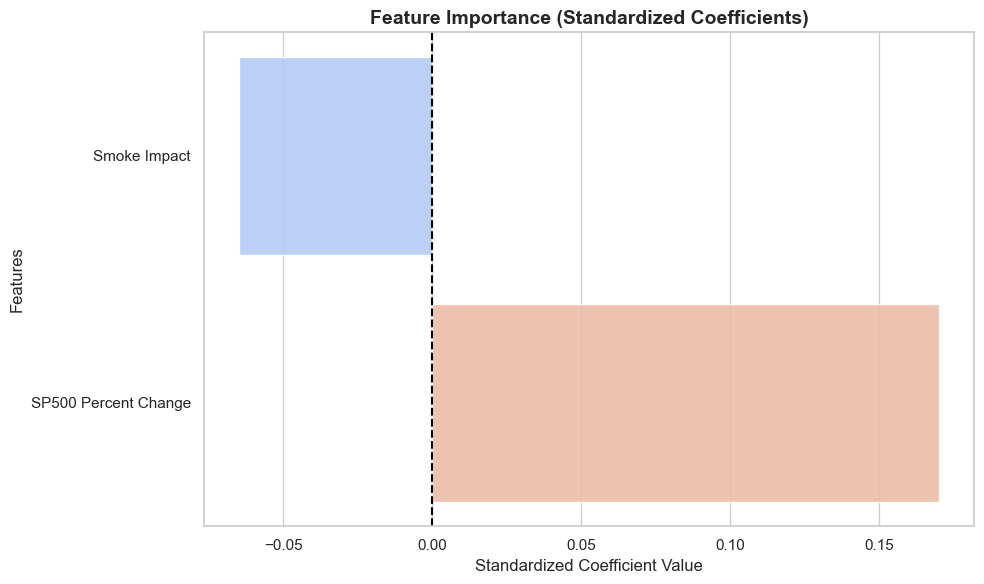

In [219]:
# Step 7: Feature Importance
coefficients = model.coef_
feature_names = features

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names, palette="coolwarm", orient="h", alpha=0.9)
plt.axvline(0, color="black", linestyle="--", linewidth=1.5)
plt.xlabel("Standardized Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance (Standardized Coefficients)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

In [215]:
# Step 8: Predict Future Economic Impact
future_smoke_impact = np.linspace(0, model_data["Smoke Impact"].max(), 100).reshape(-1, 1)
future_sp500_change = np.zeros_like(future_smoke_impact)  # Assume neutral market trend for simplicity
future_features = np.hstack([future_smoke_impact, future_sp500_change])

# Scale future features
future_features_scaled = scaler.transform(future_features)

predicted_impact = model.predict(future_features_scaled)


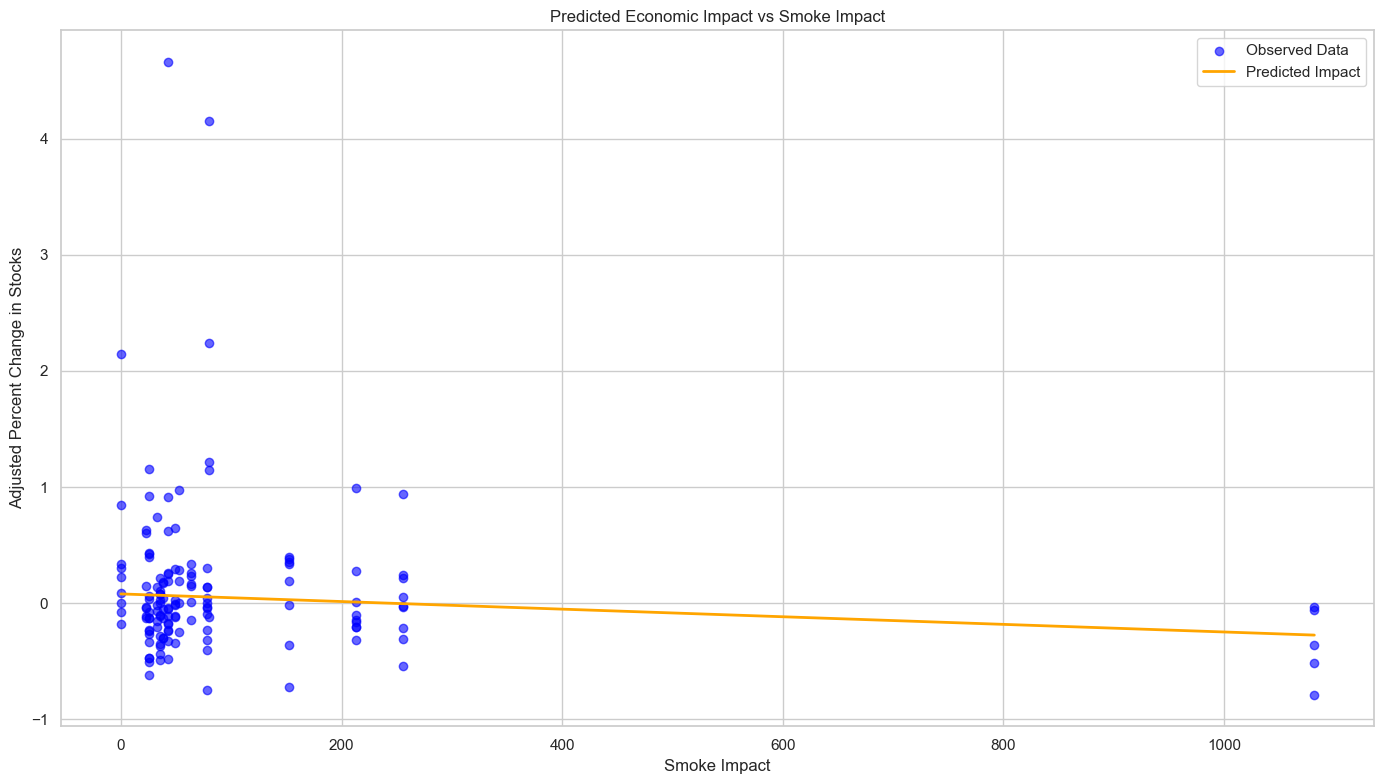

In [221]:
# Step 9: Visualize Predictions
plt.figure(figsize=(14, 8))
plt.scatter(model_data["Smoke Impact"], model_data[target], alpha=0.6, label="Observed Data", color="blue")
plt.plot(future_smoke_impact, predicted_impact, "-", label="Predicted Impact", color="orange", linewidth=2)
plt.xlabel("Smoke Impact")
plt.ylabel("Adjusted Percent Change in Stocks")
plt.title("Predicted Economic Impact vs Smoke Impact")
plt.legend()
plt.tight_layout()
plt.show()

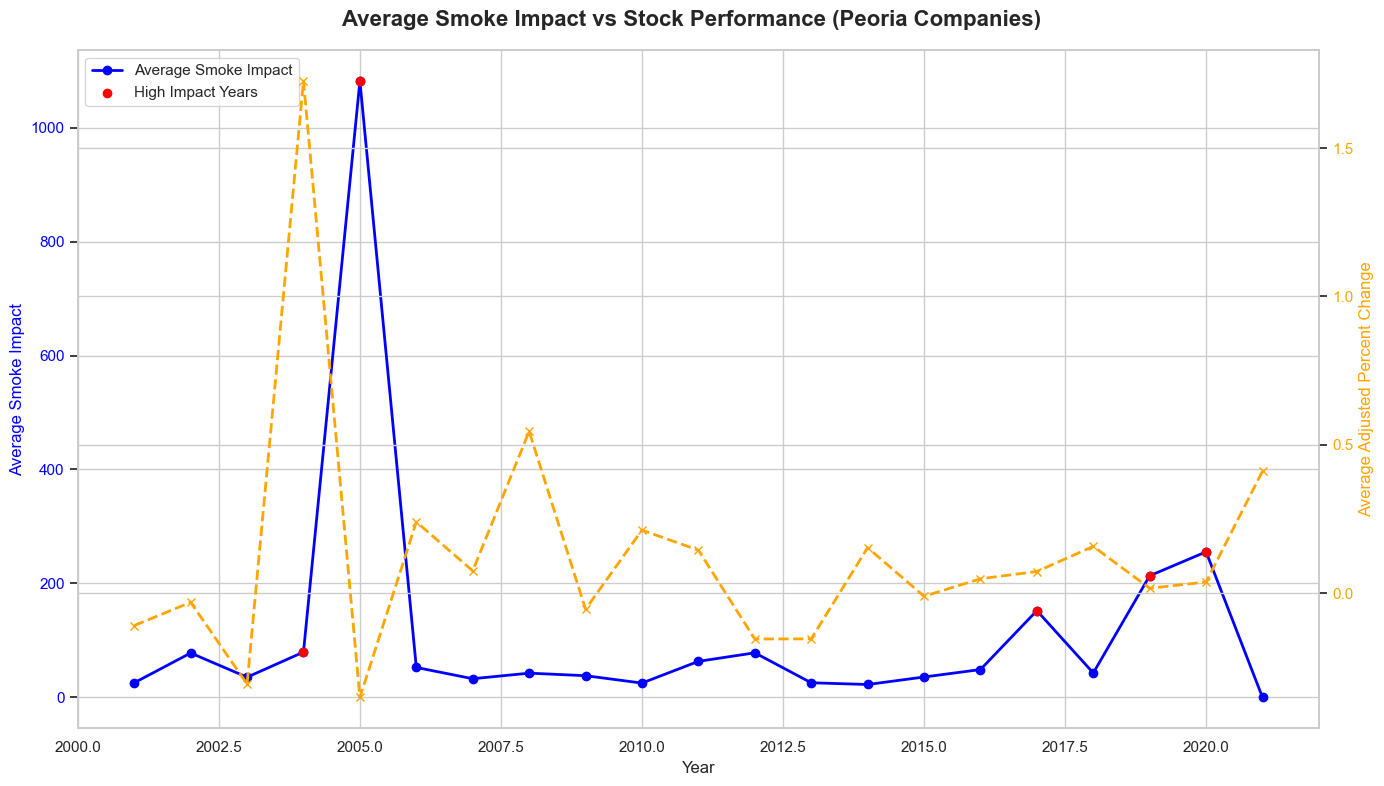

In [222]:
# Step 10: Highlight Key Years with Dual Axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Smoke Impact
color = "blue"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Average Smoke Impact", color=color, fontsize=12)
ax1.plot(aggregated_data["Year"], aggregated_data["Smoke Impact"], marker="o", color=color, label="Average Smoke Impact", linewidth=2)
ax1.tick_params(axis="y", labelcolor=color)

# Stock Performance
ax2 = ax1.twinx()
color = "orange"
ax2.set_ylabel("Average Adjusted Percent Change", color=color, fontsize=12)
ax2.plot(aggregated_data["Year"], aggregated_data["Adjusted Percent Change"], marker="x", color=color, label="Adjusted Percent Change", linewidth=2, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)

# Highlight years with high smoke impact
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]
ax1.scatter(high_impact_years["Year"], high_impact_years["Smoke Impact"], color="red", zorder=5, label="High Impact Years")

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (Peoria Companies)", fontsize=16, weight="bold")
ax1.legend(loc="upper left")
fig.tight_layout()
plt.show()

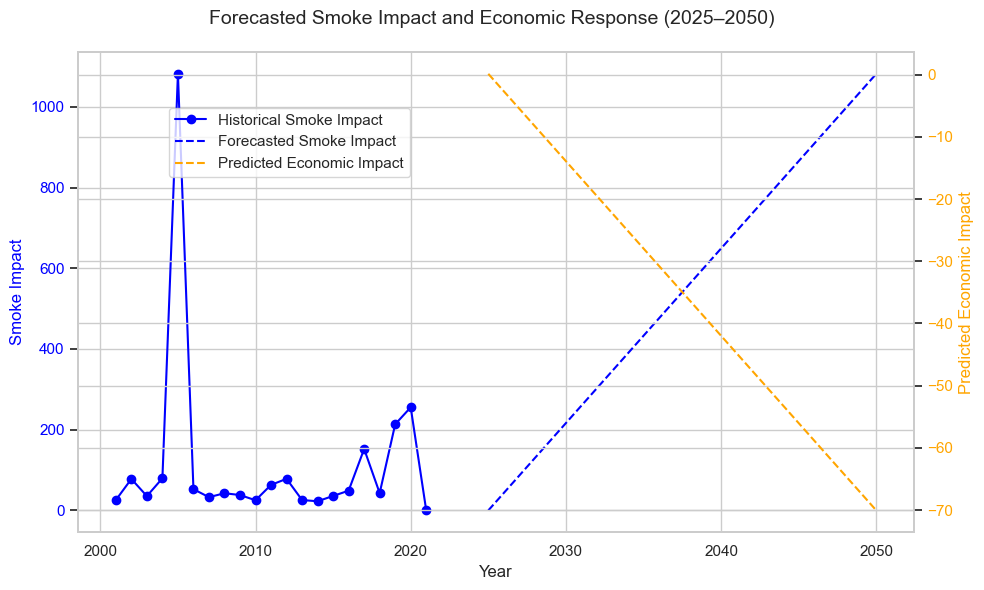

In [225]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predicted economic impact using the regression model
future_smoke_impact = np.linspace(historical_data["Smoke Impact"].min(), 
                                   historical_data["Smoke Impact"].max(), 
                                   len(future_forecast)).reshape(-1, 1)
future_sp500_change = np.zeros_like(future_smoke_impact)  # Assuming neutral market trend
future_features = np.hstack([future_smoke_impact, future_sp500_change])
future_economic_impact = model.predict(future_features)

# Add predicted economic impact to the future forecast DataFrame
future_forecast["Predicted Economic Impact"] = future_economic_impact

# Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot historical and forecasted smoke impact
ax1.plot(historical_data["Year"], historical_data["Smoke Impact"], label="Historical Smoke Impact", color="blue", marker="o")
ax1.plot(future_forecast["Year"], future_forecast["Smoke Impact"], label="Forecasted Smoke Impact", color="blue", linestyle="--")
ax1.set_xlabel("Year")
ax1.set_ylabel("Smoke Impact", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for economic impact
ax2 = ax1.twinx()
ax2.plot(future_forecast["Year"], future_forecast["Predicted Economic Impact"], label="Predicted Economic Impact", color="orange", linestyle="--")
ax2.set_ylabel("Predicted Economic Impact", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Add title and legend
fig.suptitle("Forecasted Smoke Impact and Economic Response (2025–2050)", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)
fig.tight_layout()

plt.show()
